In [90]:
from utils import *
from features import *

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from xgboost import XGBRegressor, DMatrix, cv, plot_importance
from xgboost import train as train_xgb

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])

tverskoe_issue_fix(train_df)
tverskoe_issue_fix(test_df)

Fix:  550
Fix:  149


## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [7]:
coords_train_df = pd.read_csv('data/geo/train_lat_lon.csv')
coords_train_df.drop(['key', 'tolerance_m'], axis=1, inplace=True)
coords_train_df.index = coords_train_df.id
coords_train_df.drop(['id'], axis=1, inplace=True)
coords_train_df = coords_train_df.sort_index()

coords_test_df = pd.read_csv('data/geo/test_lat_lon.csv')
coords_test_df.drop(['key', 'tolerance_m'], axis=1, inplace=True)
coords_test_df.index = coords_test_df.id
coords_test_df.drop(['id'], axis=1, inplace=True)
coords_test_df = coords_test_df.sort_index()

coords_all_df = pd.concat([coords_train_df, coords_test_df])

In [8]:
train_df['is_train'] = 1
test_df['is_train'] = 0

# coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_all_df['lat']
all_df['longitude'] = coords_all_df['lon']

## 3. Removing outliers

In [9]:
all_df = remove_outliers(all_df)

## 4. Feature engineering

In [10]:
all_df = create_new_features(all_df)

## 5. Removing fake prices

In [11]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

In [12]:
train_df = remove_fake_prices(train_df)

REMOVED: 35


In [14]:
idx_outliers = np.loadtxt('outliers/idx_outliers_full.txt').astype(int)
train_df = train_df.drop(idx_outliers)

## 6. Modeling

### `product_type == 'Investment'`

In [15]:
train_df_0 = train_df[train_df['product_type'] == 0]
test_df_0 = test_df[test_df['product_type'] == 0]

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])
X_test_0 = test_df_0.drop(['sub_area'], axis=1).copy()

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((13416, 366), (3354, 366))

In [84]:
params = {'objective': 'reg:squarederror',
          # 'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'n_estimators': 10000,
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

model_0 = XGBRegressor(**params)

model_0.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)

[0]	validation_0-rmse:8.40559	validation_1-rmse:8.39902
[1]	validation_0-rmse:7.98623	validation_1-rmse:7.98012
[2]	validation_0-rmse:7.58785	validation_1-rmse:7.58207
[3]	validation_0-rmse:7.20941	validation_1-rmse:7.20402
[4]	validation_0-rmse:6.84991	validation_1-rmse:6.84438
[5]	validation_0-rmse:6.50838	validation_1-rmse:6.50315
[6]	validation_0-rmse:6.18396	validation_1-rmse:6.17861
[7]	validation_0-rmse:5.87577	validation_1-rmse:5.87068
[8]	validation_0-rmse:5.58302	validation_1-rmse:5.57787
[9]	validation_0-rmse:5.30493	validation_1-rmse:5.30002
[10]	validation_0-rmse:5.04077	validation_1-rmse:5.03590
[11]	validation_0-rmse:4.78982	validation_1-rmse:4.78510
[12]	validation_0-rmse:4.55149	validation_1-rmse:4.54688
[13]	validation_0-rmse:4.32505	validation_1-rmse:4.32052
[14]	validation_0-rmse:4.10995	validation_1-rmse:4.10566
[15]	validation_0-rmse:3.90563	validation_1-rmse:3.90142
[16]	validation_0-rmse:3.71151	validation_1-rmse:3.70740
[17]	validation_0-rmse:3.52715	validation

XGBRegressor(base_score=7, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             nthread=-1, num_parallel_tree=1, random_state=42, reg_alpha=1,
             reg_lambda=5, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
y_pred_train = np.abs(model_0.predict(X_train))
y_pred_val = np.abs(model_0.predict(X_val))
print('___________________________________')
print('      RMSLE\n')
print('      TRAIN_0:', np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(y_pred_train))))
print(' VALIDATION_0:', np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred_val))))
print('___________________________________')
print('      MAE\n')
print('      TRAIN_0:', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
print(' VALIDATION_0:', mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_val)))

___________________________________
      RMSLE

      TRAIN_0: 0.09884386658108277
 VALIDATION_0: 0.1413390398372164
___________________________________
      MAE

      TRAIN_0: 549127.6495974957
 VALIDATION_0: 826179.8938953489


### `product_type == 'OwnerOccupier'`

In [17]:
train_df_1 = train_df[train_df['product_type'] == 1]
test_df_1 = test_df[test_df['product_type'] == 1]

X = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_1['price_doc'])
X_test_1 = test_df_1.drop(['sub_area'], axis=1).copy()

In [18]:
d_all = DMatrix(X, label=y)

In [21]:
params = {'objective': 'reg:squarederror',
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 5,
          'learning_rate': 0.05,
          'max_depth': 5,
          'min_child_weight': 5,
          'eval_metric': 'rmse',
          'subsample': 1,
          'colsample_bytree': 0.8,
          'reg_lambda': 1,
          'reg_alpha': 0,
          'seed': 42,
          'nthread': -1
          }

cv_results = cv(
    params,
    d_all,
    num_boost_round=5000,
    early_stopping_rounds=50,
    nfold=5,
    shuffle=True,
    metrics={'rmse'},
    verbose_eval=True,
    seed=42,
)

[0]	train-rmse:10.04421+0.00207	test-rmse:10.04421+0.00867
[1]	train-rmse:9.54260+0.00197	test-rmse:9.54259+0.00863
[2]	train-rmse:9.06607+0.00187	test-rmse:9.06606+0.00859
[3]	train-rmse:8.61344+0.00178	test-rmse:8.61345+0.00866
[4]	train-rmse:8.18348+0.00169	test-rmse:8.18351+0.00891
[5]	train-rmse:7.77499+0.00161	test-rmse:7.77503+0.00900
[6]	train-rmse:7.38684+0.00153	test-rmse:7.38691+0.00893
[7]	train-rmse:7.01810+0.00146	test-rmse:7.01820+0.00880
[8]	train-rmse:6.66780+0.00139	test-rmse:6.66800+0.00861
[9]	train-rmse:6.33501+0.00132	test-rmse:6.33526+0.00862
[10]	train-rmse:6.01887+0.00126	test-rmse:6.01915+0.00853
[11]	train-rmse:5.71853+0.00120	test-rmse:5.71876+0.00843
[12]	train-rmse:5.43321+0.00114	test-rmse:5.43342+0.00835
[13]	train-rmse:5.16216+0.00108	test-rmse:5.16243+0.00826
[14]	train-rmse:4.90470+0.00102	test-rmse:4.90496+0.00840
[15]	train-rmse:4.66008+0.00097	test-rmse:4.66039+0.00825
[16]	train-rmse:4.42768+0.00092	test-rmse:4.42801+0.00815
[17]	train-rmse:4.2069

In [29]:
cv_results['test-rmse-mean'].argmin()

1767

In [30]:
params = {'objective': 'reg:squarederror',
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'n_estimators': 1767,
          'base_score': 5,
          'learning_rate': 0.05,
          'max_depth': 5,
          'min_child_weight': 5,
          'eval_metric': 'rmse',
          'subsample': 1,
          'colsample_bytree': 0.8,
          'reg_lambda': 1,
          'reg_alpha': 0,
          'seed': 42,
          'nthread': -1
          }

In [31]:
model_1 = XGBRegressor(**params)
model_1.fit(X, y)

XGBRegressor(base_score=5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1767, n_jobs=8, nthread=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [44]:
from IPython.display import set_matplotlib_formats
# STYLE
plt.style.use('seaborn-ticks')
# SVG
set_matplotlib_formats('svg')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

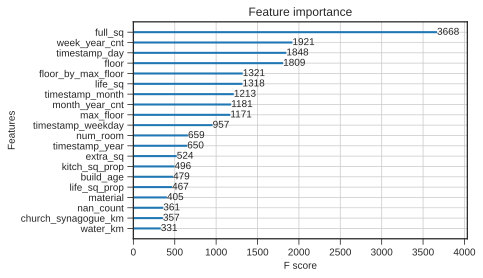

In [48]:
plot_importance(model_1, max_num_features=20)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((8793, 366), (2199, 366))

In [36]:
y_pred_train = np.abs(model_1.predict(X_train))
y_pred_val = np.abs(model_1.predict(X_val))
print('___________________________________')
print('      RMSLE\n')
print('      TRAIN_1:', np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(y_pred_train))))
print(' VALIDATION_1:', np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred_val))))
print('___________________________________')
print('      MAE\n')
print('      TRAIN_1:', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
print(' VALIDATION_1:', mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_val)))

___________________________________
      RMSLE

      TRAIN_1: 0.034815760087623465
 VALIDATION_1: 0.036300550399976955
___________________________________
      MAE

      TRAIN_1: 156318.414321051
 VALIDATION_1: 150970.77489768082


In [49]:
test_df_nan = test_df[test_df['product_type'].isna()]
X_test_nan = test_df_nan.drop(['sub_area'], axis=1).copy()

In [93]:
submission = pd.read_csv('data/submits/sample_submission.csv', index_col='id')
pred_0 = np.expm1(model_0.predict(X_test_0))
pred_1 = np.expm1(model_1.predict(X_test_1))
pred_nan = np.expm1(model_1.predict(X_test_nan))

if len(pred_0[pred_0 < 0]) or len(pred_1[pred_1 < 0]) or len(pred_nan[pred_nan < 0]):
    print('WARNING: NEGATIVE PREDICTIONS')

In [96]:
submission.loc[X_test_0.index, 'price_doc'] = 0.87*pred_0 # 0.87
submission.loc[X_test_1.index, 'price_doc'] = 0.91*pred_1 # 0.93
submission.loc[X_test_nan.index, 'price_doc'] = pred_nan # 0.95
submission.to_csv('data/submits/submission.csv', index='id')

In [97]:
!kaggle competitions submit -c sberbank-russian-housing-market -f "data/submits/submission.csv" -m "XGBRegressor splitted"

100%|████████████████████████████████████████| 121k/121k [00:03<00:00, 40.8kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [55]:
submission = pd.read_csv('data/submits/sample_submission.csv', index_col='id')
pred_0 = np.expm1(model_1.predict(X_test_0))
pred_1 = np.expm1(model_1.predict(X_test_1))
pred_nan = np.expm1(model_1.predict(X_test_nan))

if len(pred_0[pred_0 < 0]) or len(pred_1[pred_1 < 0]) or len(pred_nan[pred_nan < 0]):
    print('WARNING: NEGATIVE PREDICTIONS')

In [64]:
submission.loc[X_test_0.index, 'price_doc'] = pred_0 # 0.87
submission.loc[X_test_1.index, 'price_doc'] = 0.97*pred_1 # 0.93
submission.loc[X_test_nan.index, 'price_doc'] = pred_nan # 0.95
submission.to_csv('data/submits/submission.csv', index='id')

In [65]:
!kaggle competitions submit -c sberbank-russian-housing-market -f "data/submits/submission.csv" -m "XGBRegressor"

100%|████████████████████████████████████████| 121k/121k [00:02<00:00, 60.6kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [71]:
X = train_df.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df['price_doc'])
X_test = test_df.drop(['sub_area'], axis=1).copy()

In [67]:
d_all = DMatrix(X, label=y)

In [68]:
params = {'objective': 'reg:squarederror',
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 5,
          'learning_rate': 0.05,
          'max_depth': 5,
          'min_child_weight': 5,
          'eval_metric': 'rmse',
          'subsample': 1,
          'colsample_bytree': 0.8,
          'reg_lambda': 1,
          'reg_alpha': 0,
          'seed': 42,
          'nthread': -1
          }

cv_results = cv(
    params,
    d_all,
    num_boost_round=5000,
    early_stopping_rounds=50,
    nfold=5,
    shuffle=True,
    metrics={'rmse'},
    verbose_eval=True,
    seed=42,
)

[0]	train-rmse:10.20078+0.00077	test-rmse:10.20071+0.00310
[1]	train-rmse:9.69124+0.00073	test-rmse:9.69118+0.00290
[2]	train-rmse:9.20717+0.00070	test-rmse:9.20716+0.00273
[3]	train-rmse:8.74741+0.00066	test-rmse:8.74746+0.00256
[4]	train-rmse:8.31068+0.00063	test-rmse:8.31073+0.00240
[5]	train-rmse:7.89575+0.00060	test-rmse:7.89579+0.00232
[6]	train-rmse:7.50148+0.00057	test-rmse:7.50155+0.00209
[7]	train-rmse:7.12693+0.00054	test-rmse:7.12697+0.00191
[8]	train-rmse:6.77112+0.00052	test-rmse:6.77113+0.00174
[9]	train-rmse:6.43309+0.00049	test-rmse:6.43314+0.00160
[10]	train-rmse:6.11198+0.00046	test-rmse:6.11202+0.00146
[11]	train-rmse:5.80692+0.00044	test-rmse:5.80694+0.00138
[12]	train-rmse:5.51713+0.00042	test-rmse:5.51717+0.00131
[13]	train-rmse:5.24184+0.00040	test-rmse:5.24192+0.00119
[14]	train-rmse:4.98038+0.00038	test-rmse:4.98047+0.00109
[15]	train-rmse:4.73195+0.00036	test-rmse:4.73206+0.00105
[16]	train-rmse:4.49594+0.00034	test-rmse:4.49604+0.00101
[17]	train-rmse:4.2717

In [69]:
cv_results['test-rmse-mean'].argmin()

1341

In [70]:
params = {'objective': 'reg:squarederror',
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'n_estimators': 1340,
          'base_score': 5,
          'learning_rate': 0.05,
          'max_depth': 5,
          'min_child_weight': 5,
          'eval_metric': 'rmse',
          'subsample': 1,
          'colsample_bytree': 0.8,
          'reg_lambda': 1,
          'reg_alpha': 0,
          'seed': 42,
          'nthread': -1
          }

In [72]:
model = XGBRegressor(**params)
model.fit(X, y)

XGBRegressor(base_score=5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1340, n_jobs=8, nthread=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [73]:
from IPython.display import set_matplotlib_formats
# STYLE
plt.style.use('seaborn-ticks')
# SVG
set_matplotlib_formats('svg')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

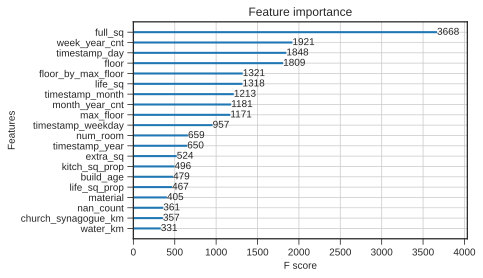

In [74]:
plot_importance(model_1, max_num_features=20)

In [75]:
submission = pd.read_csv('data/submits/sample_submission.csv', index_col='id')
pred = np.expm1(model.predict(X_test))

In [88]:
submission['price_doc'] = 0.89*pred
submission.to_csv('data/submits/submission.csv', index='id')

In [89]:
!kaggle competitions submit -c sberbank-russian-housing-market -f "data/submits/submission.csv" -m "XGBRegressor"

100%|████████████████████████████████████████| 121k/121k [00:03<00:00, 39.0kB/s]
Successfully submitted to Sberbank Russian Housing Market